## Driver Distraction Detection

### Importing the libraries and constants

In [ ]:
%pip install roboflow tensorflow scikit-learn opencv-python transformers datasets torch torchvision

In [1]:
import os
import pickle
import time
import torch

import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

from PIL import Image
import matplotlib.pyplot as plt
from transformers import BeitFeatureExtractor, BeitForSemanticSegmentation
from datasets import load_dataset
from roboflow import Roboflow
import torch.nn.functional as F
import torchvision.transforms as transforms

DISTRACTION_CLASSES = {
    0: "Safe Driving",
    1: "Texting",
    2: "Talking on the phone",
    3: "Operating the radio",
    4: "Drinking",
    5: "Reaching behind",
    6: "Hair and makeup",
    7: "Talking to passenger",
}

with open('./file_label_map.pkl', 'rb') as f:
        label_map = pickle.load(f)

FOLDERS = ['./body/', './valid']
for folder in FOLDERS:
    if not os.path.exists(folder):
        os.makedirs(folder)


d:\ejose\GitProjects\driver_detection\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Definition of model functions

In [2]:
def download_proyect(path):
    model = path.split('/')[-1]

    if model == 'base.pkl':
        rf = Roboflow(api_key='mjAeKepHoqRRVOJpbG3W')
        project = rf.workspace("new-workspace-vrhvx").project("distracted-driver-detection")
        dataset = project.version(3).download("tfrecord")

    return

In [3]:
def detect_body(image, save = False, class_index = 12, save_path = './frames', filename = 'result.png'):
    global body_model

    # Preprocesamiento de la imagen
    image = cv2.resize(image, (640, 640))

    # Inferencia
    inputs = body_model[0](images=image, return_tensors="pt")

    # Inferencia
    output = body_model[1](**inputs)
    output = output.logits
    
    logits_s = output.squeeze(0)

    # Apply softmax to convert logits to probabilities
    probs = F.softmax(logits_s, dim=0)

    # Create a binary mask for the desired class
    binary_mask = (probs[class_index, :, :] > 0.5).float()

    # Convert image to tensor
    transform = transforms.Compose([transforms.ToTensor()])
    image_tensor = transform(image).unsqueeze(0)

    # Resize the binary mask to match the image dimensions
    binary_mask_resized = F.interpolate(binary_mask.unsqueeze(0).unsqueeze(0), size=image_tensor.shape[2:], mode='nearest').squeeze(0).squeeze(0)

    # Create a dark tensor (all zeros)
    dark_tensor = torch.zeros_like(image_tensor)

    # Set the pixels outside the mask to dark
    dark_tensor[0, :, :] = dark_tensor[0, :, :] * (1 - binary_mask_resized)

    # Combine the image and binary mask
    combined_image = image_tensor * binary_mask_resized + dark_tensor

    # Convert the combined tensor back to a PIL Image
    combined_image_pil = transforms.ToPILImage()(combined_image.squeeze())
    if save:
        combined_image_pil.save(os.path.join(save_path, filename))
    return output

In [4]:
def detect_distraction(image):
    global  base_model

    # image = detect_body(image)

    return base_model.predict(image)

In [6]:
def prepare_model_data(path):
    model = path.split('/')[-1]

    if model == 'body.pkl':
        return load_dataset("hf-internal-testing/fixtures_ade20k", split="test")

    if model == 'base.pkl':
        label_map = {}
        with open("./Distracted-Driver-Detection-3/train/driver_label_map.pbtxt", "r") as file:
            lines = file.readlines()
            for i in range(0, len(lines), 5):  # Asumiendo que cada item ocupa 5 líneas
                label = lines[i + 1].split('"')[1]
                label_id = int(lines[i + 2].split(":")[1].split(",")[0].strip())
                label_map[label_id] = label

        # Leer driver.tfrecord
        raw_image_dataset = tf.data.TFRecordDataset('./Distracted-Driver-Detection-3/train/driver.tfrecord')

        # Definir las características que quieres extraer
        image_feature_description = {
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/object/class/text': tf.io.VarLenFeature(tf.string),
            'image/object/class/label': tf.io.VarLenFeature(tf.int64),
            'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
            'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
            'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
            'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
            'image/filename': tf.io.VarLenFeature(tf.string)
        }

        def _parse_image_function(example_proto):
            return tf.io.parse_single_example(example_proto, image_feature_description)

        parsed_image_dataset = raw_image_dataset.map(_parse_image_function)

        X = []
        y = []
        for image_features in parsed_image_dataset:
            image_raw = image_features['image/encoded'].numpy()
            label = image_features['image/object/class/label'].values.numpy()[0]

            # Convertir la imagen en formato raw a una matriz de numpy
            image = cv2.imdecode(np.asarray(bytearray(image_raw), dtype="uint8"), cv2.IMREAD_COLOR)
            
            # use body_model for image segmentation segm

            image = detect_body(image)

            X.append(image)
            y.append(label)

        X = np.array(X)
        y = np.array(y)

        # Convertir etiquetas a números
        categories_dict = {category: index for index, category in enumerate(set(y))}
        y = np.array([categories_dict[label] for label in y])

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

        return [X_train, X_test, y_train, y_test, categories_dict]
    return

In [5]:
# For performance purposes we will use the pre-procesed data
def prepare_model_data(path):
    model = path.split('/')[-1]

    if model == 'body.pkl':
        return load_dataset("hf-internal-testing/fixtures_ade20k", split="test")

    if model == 'base.pkl':
        files = os.listdir('./body')
        with open('./file_label_map.pkl', 'rb') as f:
            label_map = pickle.load(f)
        
        X = []
        y = []
        for file in files:
            image = cv2.imread(os.path.join('./body', file))

            X.append(image)
            y.append(label_map[file])
            
        X = np.array(X)
        y = np.array(y)

        # Convertir etiquetas a números
        categories_dict = {category: index for index, category in enumerate(set(y))}
        y = np.array([categories_dict[label] for label in y])

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

        return [X_train, X_test, y_train, y_test, categories_dict]
    return

In [7]:
def train_model(path, data):
    modelo = path.split('/')[-1]
    if modelo == 'body.pkl':
        feature_extractor = BeitFeatureExtractor.from_pretrained('microsoft/beit-base-finetuned-ade-640-640')
        body = BeitForSemanticSegmentation.from_pretrained('microsoft/beit-base-finetuned-ade-640-640')
        return [feature_extractor, body]

    if modelo == 'base.pkl':
        [X_train, X_test, y_train, y_test, categories_dict] = data
        base = None

        # Asegurarse de que todas las imágenes tienen la misma forma
        if all(i.shape == X_train[0].shape for i in X_train):

            # Normalizar datos
            X_train = X_train / 255.0
            X_test = X_test / 255.0

            # Modelo CNN
            base = Sequential()

            # Capa 1
            base.add(Conv2D(30, (3, 3), input_shape=X_train.shape[1:]))
            base.add(Activation('relu'))
            base.add(MaxPooling2D(pool_size=(2, 2)))
            base.add(Dropout(0.2))

            # Capa 2
            base.add(Conv2D(20, (3, 3), kernel_regularizer='l1'))
            base.add(Activation('relu'))

            # Capa 3
            base.add(Flatten())
            base.add(Dense(20))
            base.add(Activation('relu'))

            # Capa de salida
            base.add(Dense(len(categories_dict)))
            base.add(Activation('softmax'))

            # Compilación del modelo
            base.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

            # Entrenamiento
            base.fit(X_train, y_train, epochs=6, validation_data=(X_test, y_test))

        else:
            print("No todas las imágenes tienen la misma forma. Asegúrate de preprocesarlas para que tengan la misma forma antes de alimentarlas al modelo.")
        
        return base

In [8]:
def init_model(path):
    try:
        with open(path, 'rb') as file:
            modelo = pickle.load(file)
            print(f"Modelo {path} cargado correctamente.")

    except FileNotFoundError:
        print(f"No se encontró el archivo {path}.")
        print("Descargando proyecto...")
        proyect = download_proyect(path)

        print("Preparando datos...")
        data = prepare_model_data(path)

        print("Entrenando modelo...")
        modelo = train_model(path, data)

        print("Guardando modelo...")
        with open(path, 'wb') as file:
            pickle.dump(modelo, file)
            print("Modelo guardado correctamente.")
    
    return modelo

In [9]:
def load_models():
    global body_model, base_model

    body_model = init_model("./models/body.pkl")
    
    print()
    
    base_model = init_model("./models/base.pkl")

### Definition of statistical functions

In [30]:
def get_states_statistics():
    global label_map
    states = {}

    for file in os.listdir('./body'):
        if DISTRACTION_CLASSES[label_map[file]] in states:
            states[DISTRACTION_CLASSES[label_map[file]]] += 1
        else:
            states[DISTRACTION_CLASSES[label_map[file]]] = 1

    #Amount of images per class
    plt.figure(figsize=(20, 10))
    plt.bar(range(len(states)), list(states.values()), align='center')
    plt.xticks(range(len(states)), list(states.keys()))
    plt.show()

    #Percentage of images per class
    plt.figure(figsize=(20, 10))
    plt.pie(list(states.values()), labels=list(states.keys()), autopct='%1.1f%%')
    plt.show()

In [34]:
def show_classification_report():
    global label_map
    carpeta = "./valid"
    predictions = {}
    X = []
    y = []
    y_pred = []

    for filename in os.listdir(carpeta):
        img = cv2.imread(os.path.join(carpeta, filename))
        img = cv2.resize(img, (640,640)) 
        img = np.array(img).reshape(-1, 640, 640, 3)
        X.append(img)

        pred = detect_distraction(img)
        predictions[filename] = pred
        y_pred.append(pred)
        y.append(label_map[filename])

    y_pred_rs = [p[0] for p in y_pred]
    y_pred_classes = np.argmax(y_pred_rs,axis=1)

    # Generate and print classification report
    print(classification_report(y, y_pred_classes, target_names=DISTRACTION_CLASSES.values()))

In [35]:
def show_confusion_matrix():
    pass

### Playground

In [11]:
load_models()

Modelo ./models/body.pkl cargado correctamente.

Modelo ./models/base.pkl cargado correctamente.


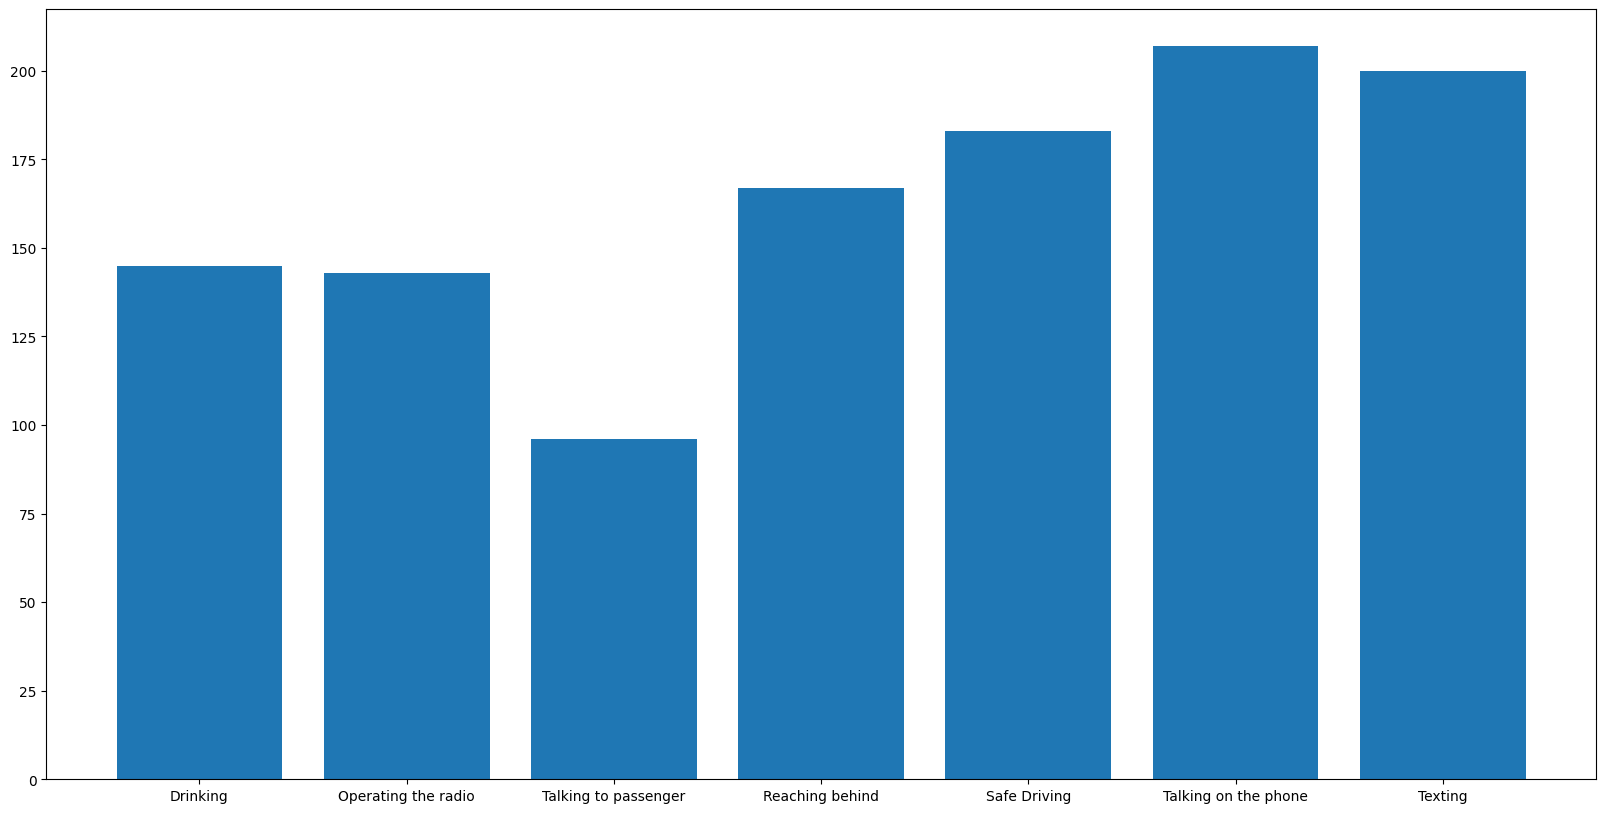

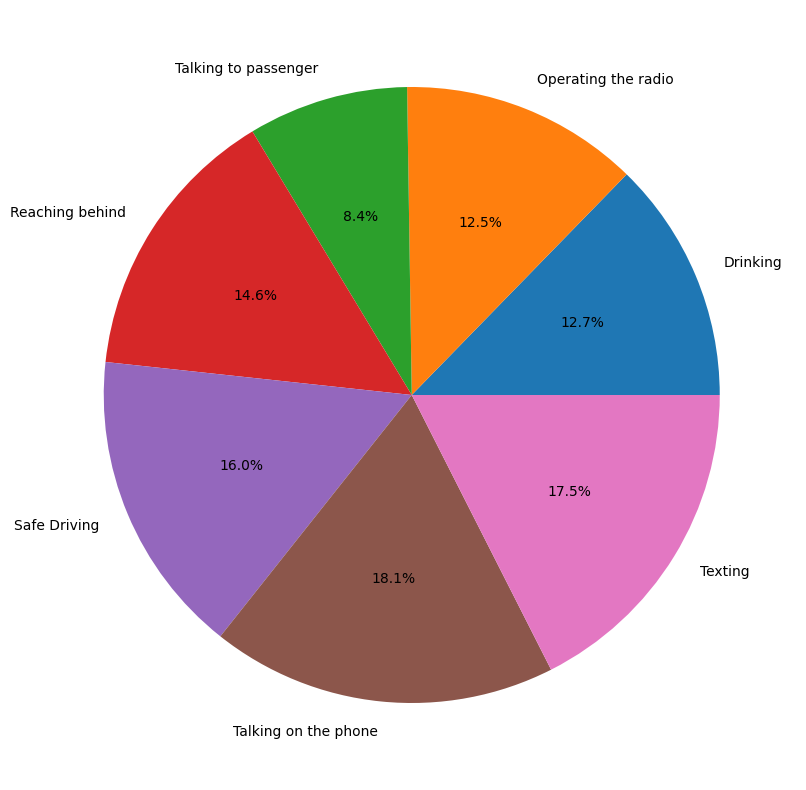

In [31]:
get_states_statistics()